plot figure of annual SLA of GAI, AI et S ensemble

In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

import multiprocessing.popen_spawn_posix
from distributed import Client

# from dask.distributed import Client
c = Client()
# c = Client(n_workers=6, threads_per_worker=1, memory_limit="8 GiB",local_directory="/gpfsscratch/rech/cli/uor98hu/dask_tmp/")
# import lib_SLXtools_IMHOTEP_2021 as slx
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35637 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:33311 Dashboard: http://127.0.0.1:35637/status,Cluster Workers: 5 Cores: 10 Memory: 20.97 GB


In [25]:
# standart librairies
import os,sys
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# save the SSH 1y for AI and S

In [3]:
# ------ mesh for constructing the weight for the computation of the global mean sea level
chunk_size2 = {"x":133,"y":320}
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size2).squeeze()
tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat

# constructing the weight
bt = (e1t * e2t).load()# area of each cell
# getting the weights to be applied to every grid cell
# masking the land cells
oceanArea = (bt*tmask[0])  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
Weight = (oceanArea/totalOceanArea).compute()


In [4]:
# loading the SSH from any run 
#--------------------------------------
##---- for WP1 runs -------------------
#--------------------------------------

## loading data with for a given experience

#-------- Read data
prefix = "eORCA025.L75-IMHOTEP"
varna = 'sossheig'

fo="1y" # output frequenc

# input directory on my work
chunk_size = {"x":133,"y":320}

for nexp in ["AI", "S"]:

    print(nexp)
    diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"+fo+"/"
    data = xr.open_mfdataset(diridatref+'????/*_gridTsurf.nc', chunks = chunk_size)[varna].fillna(0).squeeze()

    # calculating the GMSL
    GMSL = (data*Weight).sum(('x','y')).compute()
    print('GMSL done')
    # correction of the GMSL
    dataCorrected = data - GMSL
    print('correction done')
        
    #convert into dataset
    sshEds = xr.Dataset(
        data_vars=dict(sossheig=(["time_counter", "y", "x"], dataCorrected.data),
                      GMSL = (["time_counter"], GMSL.data) ),
        coords=dict(time_counter=data.time_counter.values),
        attrs=dict(
            description=" sea level heigh corrected from the GMSL",
            units="m",
            interval_write = fo))

    namo = prefix+'.'+nexp+'_y1980_2018.'+fo+'_sossheigCorrected.nc'
    print(namo)
    sshEds.to_netcdf(path='/gpfswork/rech/cli/uor98hu/MYDATA/SSH/'+nexp+'/'+namo, mode='w')



AI
GMSL done
correction done
eORCA025.L75-IMHOTEP.AI_y1980_2018.1y_sossheigCorrected.nc
S
GMSL done
correction done
eORCA025.L75-IMHOTEP.S_y1980_2018.1y_sossheigCorrected.nc


# load data

In [7]:
GAIsshBGR_1y = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/GAI_ts1980-2018_ssh_BGRbox.nc').ssh_BGRbox

In [6]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc', chunks={"x":349,"y":500}).BGRmask.squeeze()

In [14]:
AIssh_1y = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/AI/eORCA025.L75-IMHOTEP.AI_y1980_2018.1y_sossheigCorrected.nc').sossheig.where(maskBG, drop=True)
Sssh_1y = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/S/eORCA025.L75-IMHOTEP.S_y1980_2018.1y_sossheigCorrected.nc').sossheig.where(maskBG, drop=True)

In [13]:
# ------ mesh for constructing the weight for the computation of the global mean sea level
chunk_size2 = {"x":133,"y":320}
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size2).squeeze()
tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat

# constructing the weight
bt = (e1t * e2t).load()# area of each cell
# getting the weights to be applied to every grid cell
# masking the land cells
oceanArea = (bt*tmask[0]).where(maskBG, drop=True)  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
Weight = (oceanArea/totalOceanArea).compute()


In [12]:
Weight.sum()

<xarray.DataArray ()>
array(1.)
Coordinates:
    time_counter  float64 0.0
    nav_lev       float32 0.5058

In [21]:
AIsshBGR_1y = (AIssh_1y*Weight).sum(('y','x'))
SsshBGR_1y = (Sssh_1y*Weight).sum(('y','x'))

AIsshBGR_1y = AIsshBGR_1y - AIsshBGR_1y.mean()
SsshBGR_1y = SsshBGR_1y - SsshBGR_1y.mean()

In [30]:
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

ts_1y_allobs_model_AvisoGMSLcorrectionshiftedfinal.png


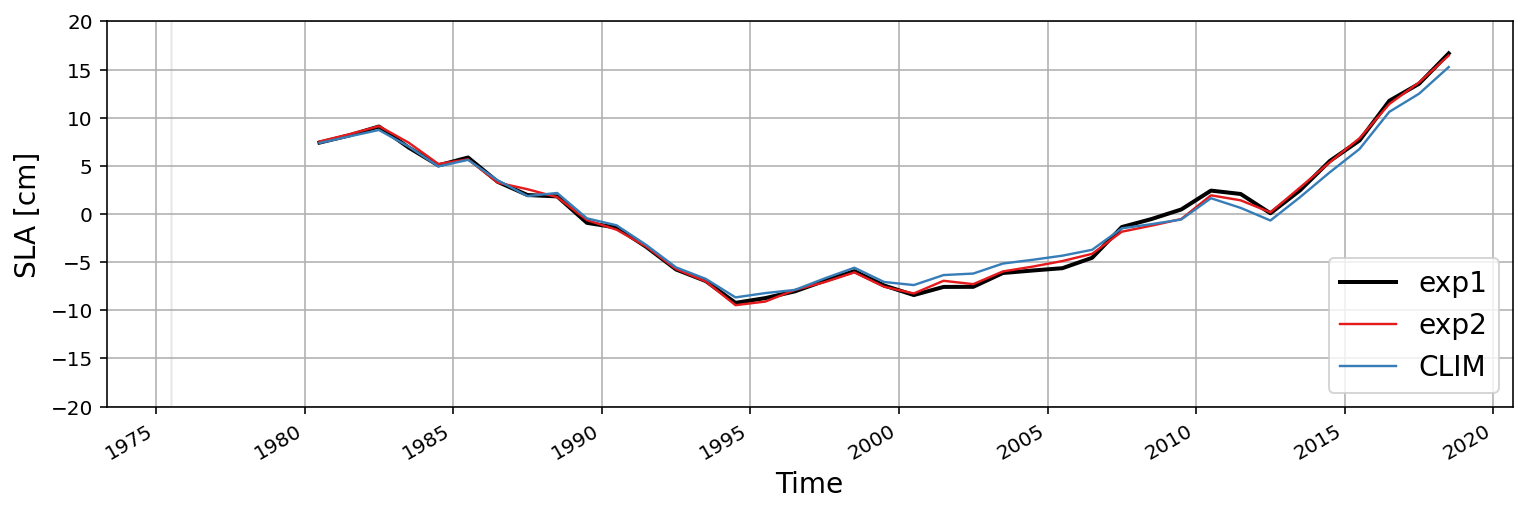

In [33]:


### yearly figure

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_1y_allobs_model_AvisoGMSLcorrectionshiftedfinal.png'
print(namo)
centim = 1/2.54  # centimeters in inches
fig ,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(32*centim, 9*centim), facecolor='none', dpi=72*2)

# fig,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(20,5), facecolor='none', dpi=72*2)

ax1.plot(AIsshBGR_1y.time_counter,GAIsshBGR_1y*100, color='k', linewidth=2)
(SsshBGR_1y*100).plot(ax=ax1, color=CB_colors['red'], linewidth=1.2)
(AIsshBGR_1y*100).plot(ax=ax1, color=CB_colors['blue'], linewidth=1.2)


ax1.grid()
ax1.legend(['exp1',"exp2",'CLIM'], fontsize = 14)
ax1.set_title('')
ax1.set_xlabel('Time',fontsize = 14); 
ax1.set_ylabel('SLA [cm]',fontsize = 14)

lim1 = -20
lim2 = 20
ax1.set_ylim(lim1,lim2)

ax1.axvspan(2005, 2018, color="grey", alpha=0.1)


plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
plt.close(fig)